In [1]:
import os
import sys
import numpy as np
import scipy.sparse.csgraph
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import seaborn as sns
from sklearn.cluster import DBSCAN
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
import itertools
plt.ion()
plt.show()

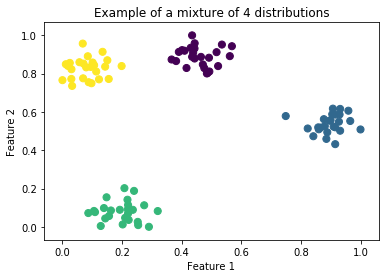

In [29]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

n_components = 4
data, truth = make_blobs(n_samples=100, centers=n_components, random_state=42, n_features=2)
data = preprocessing.MinMaxScaler().fit_transform(data)
plt.scatter(data[:, 0], data[:, 1], s=50, c = truth)
plt.title(f"Example of a mixture of {n_components} distributions")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2");


In [30]:
class DenseUnit:
    def __init__(self, dimensions, points):
        self.dimensions = dimensions
        self.points = points
    
    def __str__(self):
        return f'Dim {self.dimensions}, points {len(self.points)}'
    
    def __eq__(self, other):
        """Overrides the default implementation"""
        if isinstance(other, DenseUnit):
            return (Counter(self.dimensions) == Counter(other.dimensions) and
                   Counter(self.points) == Counter(other.points) )
        return False
    
    def __hash__(self):
        return hash(str(self))

In [31]:
N = data.shape[0] # Number of points
thresholdPoints = 2
thresholdPoints
densityThreshold = 0.3

In [32]:
def printClusters(denseUnits, data, do3D = False):
    for i in range(len(denseUnits)):
        pred = np.zeros(len(data))
        pred[denseUnits[i].points] = 1
        if do3D:
            fig = plt.figure()
            ax = Axes3D(fig)
            plt.title(f'Dimension {denseUnits[i].dimensions}, cluster {i}')
            ax.scatter(data[:, 0], data[:, 1],data[:, 2], s=50, c = pred)
            ax.set_xlabel('0')
            ax.set_ylabel('1')
            ax.set_zlabel('2')
        else:
            plt.figure()
            plt.title(f'Dimension {denseUnits[i].dimensions}, cluster {i}')
            plt.scatter(data[:, 0], data[:, 1], c = pred)
        
def getDenseUnits(points, curDim, referenceIndex = None):
    denseUnits = []
    clustering = DBSCAN(eps=0.05, min_samples=2).fit(points.reshape(-1, 1))
#     print(np.unique(clustering.labels_, return_counts=True))
    for clusterId in np.unique(clustering.labels_):
        if clusterId != -1:
            clusterPoints = np.where(clustering.labels_ == clusterId)[0]
            if referenceIndex is not None:
                clusterPoints = referenceIndex[clusterPoints]
            denseUnits.append(DenseUnit([curDim],clusterPoints))
    return denseUnits

def get1DDenseUnits(data):
    denseUnits = []
    for curDim in range(data.shape[1]):
        points = data[:, curDim]
        denseUnits.extend(getDenseUnits(points, curDim))
    return denseUnits

In [33]:
def getCandidates(prev_dim_dense_units, current_dim = 2):
    candidates = []

    for ix1, ix2 in itertools.combinations(range(len(prev_dim_dense_units)), 2):
        dims =[]
        candidate = []

        dims.extend(prev_dim_dense_units[ix1].dimensions)
        candidate.append(prev_dim_dense_units[ix1])
        points1= prev_dim_dense_units[ix1].points

        dims.extend(prev_dim_dense_units[ix2].dimensions)
        candidate.append(prev_dim_dense_units[ix2])
        points2= prev_dim_dense_units[ix2].points 
        points = np.intersect1d(points1, points2) # check points in common
        if np.unique(dims).shape[0] == current_dim and points.shape[0]>thresholdPoints:
            candidates.append(DenseUnit(np.unique(dims),points))
    return list(set(candidates))


def subclusterCandidate(data, candidate):
    """
    It is possible that the feature space on each 1D dimension becomes
    multimodal, as we removed some of the observations by the intersection
    in k dimensions.
    in order to be sure that we are not missing any subcluster, we can perform the same 
    heuristic on each candidate cluster
    """
    observations = candidate.points
    dims = candidate.dimensions
    curData =data[observations]
    current_dim = len(dims)
    denseUnits1D = []
    hasSplit = False
    for curDim in np.unique(dims):
        points = curData[:, curDim]
        newDenseUnits = getDenseUnits(points, curDim, referenceIndex=observations)
        if len(newDenseUnits)>1:
            hasSplit = True
#             print('SPLIT!', curDim)
        denseUnits1D.extend(newDenseUnits)
    if hasSplit == False: # we couldn't subcluster current cluster
        return [candidate]
    subcandidates = getCandidates(denseUnits1D, current_dim = current_dim)
    return subcandidates

In [34]:
denseUnits1D = get1DDenseUnits(data)
# printClusters(denseUnits1D, data)

In [35]:
prevDimCandidates = denseUnits1D
for subspaceDim in range(2, data.shape[1] +1):
    print(f'In yellow, clusters in {subspaceDim}')
    candidates = getCandidates(prevDimCandidates, current_dim = subspaceDim)
    prevDimCandidates = []
    for candidate in candidates:
        prevDimCandidates.extend(subclusterCandidate(data, candidate))


In yellow, clusters in 2


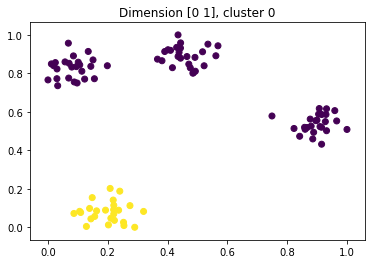

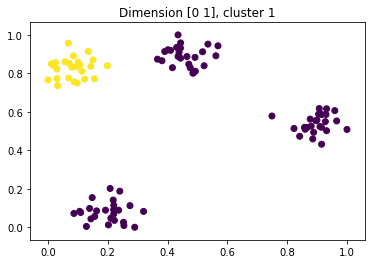

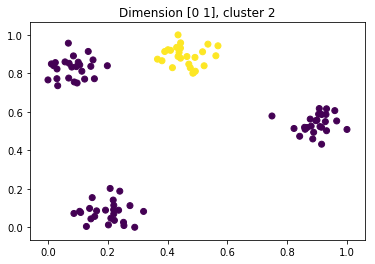

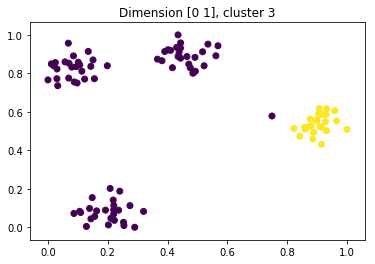

In [36]:
printClusters(prevDimCandidates, data, do3D = False)

## Evaluate results

In [37]:
def evaluateClustering(denseUnits, truth):
    from sklearn.metrics.cluster import adjusted_rand_score
    clusterAssignment = -1 * np.ones(data.shape[0])
    for i, unit in enumerate(denseUnits):
        clusterAssignment[unit.points] = i
    print('adjusted_rand_score: ', adjusted_rand_score(truth, clusterAssignment))
        
evaluateClustering(prevDimCandidates, truth)

In [ ]:
current_dim = 2
candidates = getCandidates(denseUnits1D, current_dim = current_dim)
prevDimCandidates = []
for candidate in candidates:
    prevDimCandidates.extend(subclusterCandidate(data, candidate))
printClusters(prevDimCandidates, data)

In [ ]:
current_dim = 3
candidates = getCandidates(prevDimCandidates, current_dim = current_dim)
candidates

observations = candidates[1].points
observations

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(data[observations][:, 0], data[observations][:, 1],data[observations][:, 2], s=50)
ax.set_xlabel('0')
ax.set_ylabel('1')
ax.set_zlabel('2')

i = 0
sns.distplot(data[observations][:, i])
clustering = DBSCAN(eps=0.05, min_samples=2).fit(data[observations][:, i].reshape(-1, 1))
Counter(clustering.labels_)

from scipy import stats
from scipy import signal
kernel = stats.gaussian_kde(data[observations][:, i])
x = np.linspace(min(data[observations][:, i]), max(data[observations][:, i]), 100)
y = kernel(x)
plt.plot(x, y)
from scipy.signal import argrelextrema
# print(y)
# print(1/y)
# # print(argrelextrema(y, np.less))
# print('MIN', signal.find_peaks_cwt(1/y, x))
# np.diff(y)
np.where(np.diff(np.sign(np.diff(y)))>0)[0]

In [ ]:
printClusters(candidates, data, do3D = True)

## Create one dimensionals dense units

In [ ]:
def getHistogramBins(points, xsi, curDim):
    minDim = min(points)
    maxDim = max(points)
    binSize = (maxDim - minDim)/xsi
    bins = []
    # Create histogram
    for i in range(xsi):
        endBin = minDim + binSize
#         print(i, xsi, endBin, maxDim)
        # Retrieve bin points per dimension
        if i == xsi -1 : # last bin, make sure all points are included
            binPoints = np.where((points>=minDim) & (points<=maxDim))[0]
            endBin = maxDim
        else:
            binPoints = np.where((points>=minDim) & (points<endBin))[0]
        bins.append(DenseUnit(curDim, i,minDim,endBin,binPoints))
        minDim = endBin
    return bins

In [ ]:
def mergeBins(bins, densityThreshold):
    oneDimDenseUnits = []
    # Merge bins
    for i, curBin in enumerate(bins):
        if len(oneDimDenseUnits) ==0:
            oneDimDenseUnits.append(DenseUnit(curDim,len(oneDimDenseUnits),curBin.minBin,curBin.maxBin,curBin.points))
            
        else:
            prevBin = bins[i-1]
            if np.abs(len(prevBin.points) - len(curBin.points))<= len(prevBin.points)*densityThreshold:
                lastMergedUnit = oneDimDenseUnits[-1]
                oneDimDenseUnits.remove(lastMergedUnit)
                mergedUnit = DenseUnit(curDim, len(oneDimDenseUnits),
                                       lastMergedUnit.minBin,
                                       curBin.maxBin,
                                       np.concatenate([lastMergedUnit.points, curBin.points]))
                oneDimDenseUnits.append(mergedUnit)
            else:
                oneDimDenseUnits.append(DenseUnit(curDim,len(oneDimDenseUnits),curBin.minBin,curBin.maxBin,curBin.points))
    return oneDimDenseUnits

In [ ]:
denseUnits = np.array([])
for curDim in range(data.shape[1]):
    bins = getHistogramBins(data[:, curDim], xsi, curDim)
    bins = mergeBins(bins, densityThreshold)
    denseUnits = np.concatenate([denseUnits, bins])

In [ ]:
candidates = []
grid = {i : [] for i in range(data.shape[1])}
for unit in denseUnits:
    print(unit, unit.maxBin)
    candidates.append([unit])
    if len(grid[unit.dimension]) == 0:
        grid[unit.dimension].extend([unit.minBin, unit.maxBin])
    else:
        grid[unit.dimension].append(unit.maxBin)

In [ ]:
oneDimDenseUnits = candidates

In [ ]:
plt.scatter(data[:, 0], data[:, 1])
for g in grid[0]:
    plt.axvline(x=g, c = 'red', linestyle ='--')
    
for g in grid[1]:
    plt.axhline(y=g, c = 'red', linestyle ='--')

In [ ]:
# graph = np.identity(len(candidates))
# for i in range(len(candidates)):
#     for j in range(len(candidates)):
#         graph[i, j] = int(neighbour(candidates[i], candidates[j]))

# number_of_components, component_list = scipy.sparse.csgraph.connected_components(
#         graph, directed=False)
# if debug:
#     print(graph)
#     print(number_of_components, component_list)

# candidates = np.array(candidates)


# allPred = -1 * np.ones(data.shape[0])
# # For every cluster
# for i in range(number_of_components):
#     # Get dense units of the cluster
#     cluster_dense_units = candidates[np.where(component_list == i)[0]]
#     if debug:
#         print(">>>> Connected units: ")
#         for v in cluster_dense_units:
#             for z in v:
#                 print(z)
#     clusterDimensions = {}
#     for j in range(len(cluster_dense_units)):
#         for k in range(len(cluster_dense_units[j])):
#             if cluster_dense_units[j][k].dimension not in clusterDimensions:
#                 clusterDimensions[cluster_dense_units[j][k].dimension] = []
#             clusterDimensions[cluster_dense_units[j][k].dimension].extend(cluster_dense_units[j][k].points)

#     points =reduce(np.intersect1d, list(clusterDimensions.values()))
#     allPred[points] = i
#     if plot:
#         pred = -1 * np.ones(data.shape[0])
#         pred[points] = i
#         plt.figure()
#         plt.scatter(data[:, 0], data[:, 1], c = pred)
#         for g in grid[0]:
#             plt.axvline(x=g, c = 'red', linestyle ='--')

#         for g in grid[1]:
#             plt.axhline(y=g, c = 'red', linestyle ='--')
#         plt.show()
#     if debug:
#         print(clusterDimensions.keys(), points)

In [ ]:
findClusters(oneDimDenseUnits, plot = True, debug = True);

## To do check merge 2D - 1D

In [ ]:
prev_dim_dense_units = oneDimDenseUnits
current_dim = 2

In [ ]:
import itertools
candidates = []
for ix1, ix2 in itertools.combinations(range(len(prev_dim_dense_units)), 2):
    dims =[]
    candidate = []

    for i in range(len(prev_dim_dense_units[ix1])):
        dims.append(prev_dim_dense_units[ix1][i].dimension)
        candidate.append(prev_dim_dense_units[ix1][i])
        points1= prev_dim_dense_units[ix1][i].points
        
    for i in range(len(prev_dim_dense_units[ix2])):
        dims.append(prev_dim_dense_units[ix2][i].dimension)
        candidate.append(prev_dim_dense_units[ix2][i])
        points2= prev_dim_dense_units[ix2][i].points 
    points = np.intersect1d(points1, points2) # check points in common
    if np.unique(dims).shape[0] == current_dim and points.shape[0]>thresholdPoints:
        print(f'\n\nadding candidate: {len(points)}')
        for v in candidate:
            print(v)
        candidates.append(candidate)

## Check prune

In [ ]:
for v in prev_dim_dense_units:
    for z in v:
        print(z)

In [ ]:
for i in range(len(candidates)):
    for j in range(len(candidates[i])):
        print(f'i {i}, j {j}, candidates {candidates[i][j]}')
        if not prev_dim_dense_units.__contains__([candidates[i][j]]):
            print(f'Removing {candidates[i]}')
            candidates.remove(candidates[i])
            break

In [ ]:
allPred = findClusters(candidates, plot = True, debug = True);

## Plot N-D results

In [ ]:
plt.scatter(data[:, 0], data[:, 1], c = allPred)
for g in grid[0]:
    plt.axvline(x=g, c = 'red', linestyle ='--')
    
for g in grid[1]:
    plt.axhline(y=g, c = 'red', linestyle ='--')

In [ ]:
findClusters(candidates, plot = True, debug = True);

In [ ]:
def findClusters(candidates, plot = False, debug = False):
    graph = np.identity(len(candidates))
    for i in range(len(candidates)):
        for j in range(len(candidates)):
            graph[i, j] = int(neighbour(candidates[i], candidates[j]))

    number_of_components, component_list = scipy.sparse.csgraph.connected_components(
            graph, directed=False)
    if debug:
        print(graph)
        print(number_of_components, component_list)

    candidates = np.array(candidates)


    allPred = -1 * np.ones(data.shape[0])
    # For every cluster
    for i in range(number_of_components):
        # Get dense units of the cluster
        cluster_dense_units = candidates[np.where(component_list == i)[0]]
        if debug:
            print(">>>> Connected units: ")
            for v in cluster_dense_units:
                for z in v:
                    print(z)
        clusterDimensions = {}
        for j in range(len(cluster_dense_units)):
            for k in range(len(cluster_dense_units[j])):
                if cluster_dense_units[j][k].dimension not in clusterDimensions:
                    clusterDimensions[cluster_dense_units[j][k].dimension] = []
                clusterDimensions[cluster_dense_units[j][k].dimension].extend(cluster_dense_units[j][k].points)

        points =reduce(np.intersect1d, list(clusterDimensions.values()))
        allPred[points] = i
        if plot:
            pred = -1 * np.ones(data.shape[0])
            pred[points] = i
            plt.figure()
            plt.scatter(data[:, 0], data[:, 1], c = pred)
            for g in grid[0]:
                plt.axvline(x=g, c = 'red', linestyle ='--')

            for g in grid[1]:
                plt.axhline(y=g, c = 'red', linestyle ='--')
            plt.show()
        if debug:
            print(clusterDimensions.keys(), points)
    return allPred

In [ ]:
# denseUnits = np.array([])

# for curDim in range(data.shape[1]):
    
#     minDim = min(data[:,curDim])
#     maxDim = max(data[:,curDim])
#     binSize = (maxDim - minDim)/xsi
#     points = data[:, curDim]
#     bins = []
#     # Create histogram
#     for i in range(xsi):
#         endBin = minDim + binSize
# #         print(i, xsi, endBin, maxDim)
#         # Retrieve bin points per dimension
#         if i == xsi -1 : # last bin, make sure all points are included
#             binPoints = np.where((points>=minDim) & (points<=maxDim))[0]
#             endBin = maxDim
#         else:
#             binPoints = np.where((points>=minDim) & (points<endBin))[0]
#         bins.append(DenseUnit(curDim, i,minDim,endBin,binPoints))
#         minDim = endBin
#     oneDimDenseUnits = []
#     # Merge bins
#     for i, curBin in enumerate(bins):
#         if len(oneDimDenseUnits) ==0:
#             oneDimDenseUnits.append(DenseUnit(curDim,len(oneDimDenseUnits),curBin.minBin,curBin.maxBin,curBin.points))
            
#         else:
#             prevBin = bins[i-1]
#             if np.abs(len(prevBin.points) - len(curBin.points))<= len(prevBin.points)*densityThreshold:
# #                 print('merging')
#                 # merge
#                 lastMergedUnit = oneDimDenseUnits[-1]
#                 oneDimDenseUnits.remove(lastMergedUnit)
#                 mergedUnit = DenseUnit(curDim, len(oneDimDenseUnits),
#                                        lastMergedUnit.minBin,
#                                        curBin.maxBin,
#                                        np.concatenate([lastMergedUnit.points, curBin.points]))
#                 oneDimDenseUnits.append(mergedUnit)
#             else:
# #                 print('not merging')
#                 oneDimDenseUnits.append(DenseUnit(curDim,len(oneDimDenseUnits),curBin.minBin,curBin.maxBin,curBin.points))
# #         print('adding ', oneDimDenseUnits[-1])
#     denseUnits = np.concatenate([denseUnits, oneDimDenseUnits])